In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import re
import unicodedata
import datetime
import itertools
%matplotlib inline

## Load data

In [3]:
def timestamp_to_datetime(timestamp):
    return datetime.date(timestamp.year, timestamp.month, timestamp.day)

In [197]:
g_dat = pd.read_excel('data/box_scores/box_score_2017.xlsx')

In [198]:
g_dat.head()

,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,ft,...,stl_pct,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season
0,0,2,3,5,3,0.60,5,0.385,13,3,...,1.5,11.3,11.0,0.512,22.7,1,201610250CLE,NYK,2016-10-25,2017
1,3,0,4,8,1,0.25,4,0.444,18,2,...,1.6,17.5,8.6,0.503,32.1,1,201610250CLE,NYK,2016-10-25,2017
2,1,1,1,7,1,0.50,2,0.412,17,2,...,0.0,18.3,5.2,0.475,31.2,1,201610250CLE,NYK,2016-10-25,2017
3,0,1,2,0,0,0.00,2,0.000,5,0,...,0.0,28.6,7.9,0.000,15.1,1,201610250CLE,NYK,2016-10-25,2017
4,3,0,5,0,0,NaN,0,0.000,1,0,...,2.5,50.0,15.9,0.000,4.3,1,201610250CLE,NYK,2016-10-25,2017


In [4]:
def fix_dates(df):
    df = df.reset_index()
    datetimes = []
    for timestamp in df['date']:
        datetimes.append(timestamp_to_datetime(timestamp))
    df['datetime'] = datetimes
    return df

In [200]:
# Weird discrepancy in excel changed datetimes to timestamps--change them back
g_dat = fix_dates(g_dat)

## Create Gini for each game

In [5]:
def get_reg_season(df, yr):
    return df[(df['datetime'] < datetime.date(yr,4,1)) | (df['g_num'] > 7)]

In [6]:
def get_playoffs(df, yr):
    return df[(df['datetime'] > datetime.date(yr,4,1)) & (df['g_num'] <= 7)]

In [7]:
def get_game(df, gid, team):
    return df[(df['g_id'] == gid) & (df['team'] == team)]

In [204]:
g_dat_reg = get_reg_season(g_dat, 2017)
g_dat_reg.head()

,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
0,0,0,2,3,5,3,0.60,5,0.385,13,...,11.3,11.0,0.512,22.7,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
1,1,3,0,4,8,1,0.25,4,0.444,18,...,17.5,8.6,0.503,32.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
2,2,1,1,1,7,1,0.50,2,0.412,17,...,18.3,5.2,0.475,31.2,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
3,3,0,1,2,0,0,0.00,2,0.000,5,...,28.6,7.9,0.000,15.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
4,4,3,0,5,0,0,NaN,0,0.000,1,...,50.0,15.9,0.000,4.3,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25


In [205]:
len(np.unique(g_dat['g_id']))

1309

In [206]:
# 1189 games played in the regular season--82 games each for 29 teams (divided by 2)
# 1230 games played in the regular season--82 games each for 30 teams (divided by 2)
len(np.unique(g_dat_reg['g_id']))

1230

In [207]:
game_dict = {tuple(game) for game in zip(g_dat_reg['g_id'], g_dat_reg['team'])}

In [208]:
# 2378 games--82 games each for 29 teams
# 2460 games--82 games each for 30 teams
len(game_dict)

2460

In [209]:
g_dat_reg[g_dat_reg['team'] == 'OKC'].head()

,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
217,0,9,0,11,11,1,0.500,2,0.524,21,...,7.2,16.5,0.619,31.8,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
218,1,1,0,3,7,0,NaN,0,0.438,16,...,10.6,7.0,0.474,22.1,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
219,2,3,1,5,0,0,NaN,0,0.000,2,...,0.0,11.0,0.133,4.9,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
220,3,1,1,3,4,0,0.000,5,0.250,16,...,14.8,9.6,0.289,32.4,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
221,4,0,0,4,2,1,0.333,3,0.400,5,...,0.0,12.2,0.500,12.7,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26


In [210]:
g_info = ('201610300OKC','OKC')

In [211]:
g1 = get_game(g_dat_reg, g_info[0], g_info[1])
adj_usg = [usg*(mp/60) for usg, mp in zip(g1['usg_pct'], g1['sec'])]
adj_usg_2 = [usg*((float(mp)/60)**2) for usg, mp in zip(g1['usg_pct'], g1['sec'])]
pd.DataFrame({'usg': g1['usg_pct'], 
              'min': [float(s)/60 for s in g1['sec']], 
              'adj_usg': adj_usg,
              'adj_usg_2': adj_usg_2})

,adj_usg,adj_usg_2,min,usg
864,950.0,36800.027778,38.366667,25.0
865,1188.0,40763.610000,33.650000,36.0
866,312.0,9391.226000,30.050000,10.4
867,577.1,17396.336778,29.566667,19.9
868,34.8,268.192000,6.800000,5.8
869,307.5,8113.493417,25.683333,12.3
870,491.4,11257.064000,21.933333,23.4
871,292.0,5888.768056,20.083333,14.6
872,196.2,3603.906361,18.183333,10.9
873,70.0,626.736111,7.916667,10.0


In [212]:
usg_adj = [usg*((float(mp)/60)**2) for usg, mp in zip(g1['usg_pct'], g1['sec'])]
print usg_adj
usg_norm = [u/sum(usg_adj) for u in usg_adj]
print usg_norm
print sum(usg_norm)

[36800.02777777778, 40763.61, 9391.226, 17396.33677777778, 268.19199999999995, 8113.493416666667, 11257.064, 5888.768055555554, 3603.9063611111114, 626.7361111111111, 1175.3630000000003, 166.66402777777776]
[0.2716843913483794, 0.3009464188149447, 0.06933281505199854, 0.12843232613036326, 0.0019799871001321434, 0.05989967002001205, 0.08310777914837858, 0.0434751401446361, 0.026606640410915223, 0.0046270187596460215, 0.00867737881060068, 0.0012304342599930842]
1.0


In [8]:
# df: the dataframe being used
# gid: the game id you want
# team: the team from that game you want
# n: the power raising minutes played to
def get_norm_usg(df, gid, team, n):
    game = get_game(df, gid, team)
    usg_adj = [usg*((float(mp)/60)**n) for usg, mp in zip(game['usg_pct'], game['sec'])]
    usg_norm = [u/sum(usg_adj) for u in usg_adj]
    return sorted(usg_norm)

In [214]:
n_usg = get_norm_usg(g_dat_reg, g_info[0], g_info[1], 2)

In [215]:
n_usg

[0.0012304342599930842,
 0.0019799871001321434,
 0.0046270187596460215,
 0.00867737881060068,
 0.026606640410915223,
 0.0434751401446361,
 0.05989967002001205,
 0.06933281505199854,
 0.08310777914837858,
 0.12843232613036326,
 0.2716843913483794,
 0.3009464188149447]

In [216]:
np.cumsum(n_usg)

array([ 0.00123043,  0.00321042,  0.00783744,  0.01651482,  0.04312146,
        0.0865966 ,  0.14649627,  0.21582908,  0.29893686,  0.42736919,
        0.69905358,  1.        ])

In [9]:
# n_usg: the normalized usage vector (sums to 1)
# k: how many players should be used in calculating gini
def get_norm_top_k(n_usg, k):
    new_usg = n_usg[-k:]
    return [u/sum(new_usg) for u in new_usg]

In [218]:
n_usg[-5:]

[0.06933281505199854,
 0.08310777914837858,
 0.12843232613036326,
 0.2716843913483794,
 0.3009464188149447]

In [219]:
n_usg_5 = get_norm_top_k(n_usg, 5)

In [220]:
n_usg_5

[0.0812331716603794,
 0.09737248494540299,
 0.15047658439174968,
 0.3183165833277735,
 0.35260117567469446]

In [221]:
print len(n_usg_5)
print sum(n_usg_5)

5
1.0


In [222]:
# For gini to be 1
#n_usg = [0]*20 + [1]
#n_usg

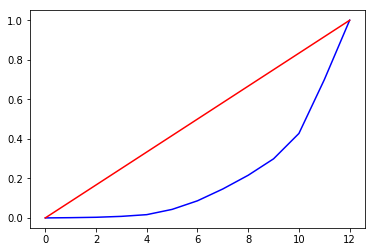

In [223]:
#x = [float(t)/(len(n_usg)) for t in range(len(n_usg)+1)]
x = range(len(n_usg)+1)
y1 = np.cumsum([0] + n_usg)
# For gini=1
#y1 = np.full(11,0)
#y1[len(y1)-1] = 1
y2 = [float(t)/(len(x)-1) for t in x]
#y2 = [float(t)/(len(n_usg)) for t in range(len(n_usg)+1)]
plt.plot(x, y1, c='b')
plt.plot(x, y2, c='r')
plt.show()

In [224]:
print np.trapz(y2), np.trapz(y1)

6.0 2.44619616229


In [225]:
area_under_curve = np.trapz(y1, dx=float(1)/len(y1)) #* len(y1)/(len(y1)-1)
print area_under_curve
# Multiply by 2 so the max is 1 and min is 0
print 'Gini:', round((1 - 2*area_under_curve) * len(y1)/(len(y1)-1), 3)

0.188168935561
Gini: 0.676


In [226]:
x[-1]*y1[-1]

11.999999999999996

In [227]:
2*(np.trapz(y2, x=x) - np.trapz(y1, x=x)) * len(n_usg)/(len(n_usg)-1)

7.7537538277322531

In [228]:
2 * (np.trapz(y2) - np.trapz(y1))

7.1076076754212316

In [229]:
# Multiply by constant so max is 1
2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg)/(len(n_usg)-1)

0.64614615231102124

In [230]:
y1[-1]

0.99999999999999978

In [231]:
y1

array([ 0.        ,  0.00123043,  0.00321042,  0.00783744,  0.01651482,
        0.04312146,  0.0865966 ,  0.14649627,  0.21582908,  0.29893686,
        0.42736919,  0.69905358,  1.        ])

In [10]:
def get_gini_game(df, gid, team, k, n):
    norm_usg = get_norm_usg(df, gid, team, n)
    norm_usg_k = get_norm_top_k(norm_usg, k)
    x = range(len(norm_usg_k) + 1)
    y1 = np.cumsum([0] + norm_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    # area under curve times 2 multiplied by a constant to account for offset
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(norm_usg_k)/(len(norm_usg_k)-1)
    return gini

In [233]:
g_info = ('201610300OKC','OKC')
gid = g_info[0]
team = g_info[1]
get_gini_game(g_dat_reg, gid, team, k=5, n=2)

print gid
print team
#gid = key[0]
#team = key[1]
temp_df = g_dat_reg[g_dat_reg['g_id'] == gid]
teams = list(np.unique(temp_df['team']))
teams.remove(team)

opponent = str(teams[0])
print opponent

game = get_game(g_dat_reg, gid, team)
date = game['datetime'].iloc[0]
print date
g_num = game['g_num'].iloc[0]
print g_num
gini = get_gini_game(g_dat_reg, gid, team, k=9, n=2)
print gini

201610300OKC
OKC
LAL
2016-10-30
3
0.528500061064


In [11]:
def plot_gini_game(df, gid, team, k, n):
    norm_usg = get_norm_usg(df, gid, team, n)
    norm_usg_k = get_norm_top_k(norm_usg, k)
    x = range(len(norm_usg_k) + 1)
    y1 = np.cumsum([0] + norm_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    # area under curve times 2 multiplied by a constant to account for offset
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(norm_usg_k)/(len(norm_usg_k)-1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_title('axes title')

    ax.set_xlabel('Player')
    ax.set_ylabel('Cumulative weighted usage')

    ax.text(1.5, 0.5, 'Gini: '+ str(round(gini,3)), fontsize=12)
    
    ax.plot(x, y1, c='black')
    ax.plot(x, y2, c='black')
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='b', interpolate=True)
    ax.set_title('Team: ' + team + ', Date: ' + gid[4:6] + '/' + gid[6:8] + '/' + gid[0:4])
    plt.show()

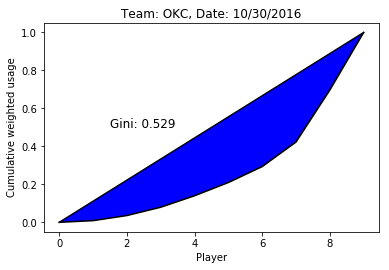

In [235]:
plot_gini_game(g_dat_reg, gid, team, k=9, n=2)

In [178]:
gini_log = pd.DataFrame()
gini_log = gini_log.append({'g_id': gid,
                            'team': team,
                            'opp': opponent,
                            'date': date,
                            'g_num': g_num,
                            'gini': gini},
                            ignore_index=True)

In [179]:
gini_log

,date,g_id,g_num,gini,opp,team
0,2016-10-30,201610300OKC,3.0,0.5285,LAL,OKC


In [12]:
def get_gini_season(df, n):
    game_dict = {tuple(game) for game in zip(df['g_id'], df['team'])}
    gini_log = pd.DataFrame()
    for key in game_dict:
        #print key
        gid = key[0]
        team = key[1]
        temp_df = df[df['g_id'] == gid]
        teams = list(np.unique(temp_df['team']))
        teams.remove(team)
        opponent = str(teams[0])
        game = get_game(df, gid, team)
        date = game['datetime'].iloc[0]
        g_num = game['g_num'].iloc[0]
        gini_2 = get_gini_game(df, gid, team, k=2, n=n)
        gini_3 = get_gini_game(df, gid, team, k=3, n=n)
        gini_4 = get_gini_game(df, gid, team, k=4, n=n)
        gini_5 = get_gini_game(df, gid, team, k=5, n=n)
        gini_6 = get_gini_game(df, gid, team, k=6, n=n)
        gini_7 = get_gini_game(df, gid, team, k=7, n=n)
        gini_8 = get_gini_game(df, gid, team, k=8, n=n)
        gini_9 = get_gini_game(df, gid, team, k=9, n=n)
        gini_10 = get_gini_game(df, gid, team, k=10, n=n)
        #opp_gini = get_gini(g_dat_reg, gid, opponent)
        gini_log = gini_log.append({'g_id': gid,
                            'team': team,
                            'opp': opponent,
                            'date': date,
                            'g_num': int(g_num),
                            'gini_2': gini_2,
                            'gini_3': gini_3,
                            'gini_4': gini_4,
                            'gini_5': gini_5,
                            'gini_6': gini_6,
                            'gini_7': gini_7,
                            'gini_8': gini_8,
                            'gini_9': gini_9,
                            'gini_10': gini_10,
                            #'opp_gini': opp_gini
                            },
                            ignore_index=True)
    return gini_log 

In [184]:
yr = 2008
team = 'BOS'
g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
g_dat = fix_dates(g_dat)
g_dat_reg = get_reg_season(g_dat, yr)
g_dat_reg_team = g_dat_reg[g_dat_reg['team'] == team]
game_dict = {tuple(game) for game in zip(g_dat_reg_team['g_id'], g_dat_reg_team['team'])}

In [185]:
gini_season = []
for key in game_dict:
    ginis = get_gini_game(g_dat_reg_team, key[0], key[1], k=9, n=2)
    gini_season.append(ginis)

np.mean(gini_season)

0.46414517892555862

## Create gini for each game in a season

In [1076]:
#yrs = range(1986,2018)
ns = range(1,5)
yrs = range(2012,2018)
for n in ns:
    for yr in yrs:
        print yr, n
        g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
        g_dat = fix_dates(g_dat)
        g_dat_reg = get_reg_season(g_dat, yr)
        gini_log = get_gini_season(g_dat_reg, n)
        gini_log['season'] = np.full(gini_log.shape[0], yr)
        gini_log.to_excel('data/game_ginis/game_gini_' + str(yr) + '_mp' + str(n) + '.xlsx')

2012 1
2013 1
2014 1
2015 1
2016 1
2017 1
2012 2
2013 2
2014 2
2015 2
2016 2
2017 2
2012 3
2013 3
2014 3
2015 3
2016 3
2017 3
2012 4
2013 4
2014 4
2015 4
2016 4
2017 4


In [466]:
#bos_gini_2017 = gini_log[gini_log['team'] == 'BOS']

In [467]:
#np.mean(bos_gini_2000['gini'])

0.3167673257014149

In [468]:
#bos_gini_2000.shape[0]

82

## Find what pct. of work is done by top k players

In [13]:
yr = 2017
g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
g_dat = fix_dates(g_dat)
g_dat_reg = get_reg_season(g_dat, yr)

In [14]:
print g_dat_reg.shape
g_dat_reg.head()

(26137, 44)


,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
0,0,0,2,3,5,3,0.60,5,0.385,13,...,11.3,11.0,0.512,22.7,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
1,1,3,0,4,8,1,0.25,4,0.444,18,...,17.5,8.6,0.503,32.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
2,2,1,1,1,7,1,0.50,2,0.412,17,...,18.3,5.2,0.475,31.2,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
3,3,0,1,2,0,0,0.00,2,0.000,5,...,28.6,7.9,0.000,15.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
4,4,3,0,5,0,0,NaN,0,0.000,1,...,50.0,15.9,0.000,4.3,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25


In [32]:
game_dict = {tuple(game) for game in zip(g_dat_reg['g_id'], g_dat_reg['team'])}

In [64]:
k = 9
gid = '201704120BOS'
team = 'BOS'
temp_df = g_dat_reg[g_dat_reg['g_id'] == gid]
teams = list(np.unique(temp_df['team']))
teams.remove(team)
opponent = str(teams[0])
game = get_game(g_dat_reg, gid, team)
#date = game['datetime'].iloc[0]
#g_num = game['g_num'].iloc[0]
n_usg = get_norm_usg(temp_df, gid, team, 1)
sum(n_usg[-k:])

0.9128738102527045

In [102]:
def get_usg_of_top_k(df, gid, team, k):
    temp_df = df[df['g_id'] == gid]
    #teams = list(np.unique(temp_df['team']))
    #teams.remove(team)
    #game = get_game(temp_df, gid, team)
    n_usg = get_norm_usg(temp_df, gid, team, 1)
    sum_n_usg_top_k = sum(n_usg[-k:])
    return sum_n_usg_top_k

In [114]:
k = 11
gid = '201704120BOS'
team = 'BOS'
get_usg_of_top_k(g_dat_reg, gid, team, k)

0.9829924535086569

In [121]:
def get_avg_usg_of_top_k(yr, k):
    g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
    g_dat = fix_dates(g_dat)
    g_dat_reg = get_reg_season(g_dat, yr)
    game_dict = {tuple(game) for game in zip(g_dat_reg['g_id'], g_dat_reg['team'])}
    usg_lst = []
    for key in game_dict:
        gid = key[0]
        team = key[1]
        usg_lst.append(get_usg_of_top_k(g_dat_reg, gid, team, k))
        
    return np.nanmean(usg_lst)

In [119]:
gid = '200511010NOK'
team = 'SAC'
get_usg_of_top_k(g_dat_reg, gid, team, 8)

0.8694086006013595

In [122]:
get_avg_usg_of_top_k(2006,8)

0.95616500466776211

In [124]:
avg_usg_df = pd.DataFrame()
yrs = range(2003,2018)
for yr in yrs:
    avg_usg_df = avg_usg_df.append({
            'yr': yr,
            'top8': get_avg_usg_of_top_k(yr,8),
            'top9': get_avg_usg_of_top_k(yr,9)
        }, ignore_index=True)

In [125]:
avg_usg_df

,top8,top9,yr
0,0.952308,0.980432,2003.0
1,0.954562,0.982013,2004.0
2,0.951610,0.980192,2005.0
3,0.956165,0.981832,2006.0
4,0.953676,0.980455,2007.0
5,0.952504,0.980088,2008.0
6,0.955501,0.982257,2009.0
7,0.951431,0.980626,2010.0
8,0.947045,0.978262,2011.0
9,0.938726,0.972838,2012.0


In [131]:
np.mean(avg_usg_df['top9'])

0.9768696035281059

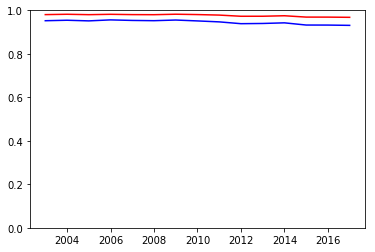

In [130]:
plt.plot(avg_usg_df['yr'], avg_usg_df['top8'], c='b')
plt.plot(avg_usg_df['yr'], avg_usg_df['top9'], c='r')
plt.ylim(0,1)
plt.show()

In [63]:
for key in game_dict:
    k = 9
    gid = '201704120BOS'
    team = 'BOS'
    temp_df = g_dat_reg[g_dat_reg['g_id'] == gid]
    teams = list(np.unique(temp_df['team']))
    teams.remove(team)
    opponent = str(teams[0])
    game = get_game(g_dat_reg, gid, team)
    #date = game['datetime'].iloc[0]
    #g_num = game['g_num'].iloc[0]
    n_usg = get_norm_usg(temp_df, gid, team, 1)
    sum(n_usg[-k:])

KeyboardInterrupt: 

In [33]:
len(game_dict)

2460

In [24]:
x = zip(g_dat_reg['team'], g_dat_reg['g_id'])

In [29]:
np.unique(x)[0]

u'201610250CLE'

In [30]:
new_df = g_dat_reg.crosstab("team", "g_id")

AttributeError: 'DataFrame' object has no attribute 'crosstab'

In [17]:
mytable = g_dat_reg.groupby(['g_id','team']).size()

KeyError: 'g_id'

In [ ]:
#yrs = range(1986,2018)
yrs = range(2012,2018)
for yr in yrs:
    print yr, n
    g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
    g_dat = fix_dates(g_dat)
    g_dat_reg = get_reg_season(g_dat, yr)
    gini_log = get_gini_season(g_dat_reg, n)
    gini_log['season'] = np.full(gini_log.shape[0], yr)
    gini_log.to_excel('data/game_ginis/game_gini_' + str(yr) + '_mp' + str(n) + '.xlsx')

## Reading in Gini tables

In [5]:
links = ['data/game_ginis/game_gini_' + str(yr) + '_mp2.xlsx' for yr in range(1986,2018)]

In [6]:
int(links[0][26:30])

1986

In [19]:
gini_log = pd.read_excel(links[-1])

In [20]:
gini_log

,date,g_id,g_num,gini_10,gini_2,gini_3,gini_4,gini_5,gini_6,gini_7,gini_8,gini_9,opp,team,season
0,2017-01-02,201701020CHI,35,0.398791,0.073116,0.277656,0.306659,0.302640,0.288699,0.330913,0.366787,0.398791,CHI,CHH,2017
1,2017-04-12,201704120BOS,82,0.264407,0.060914,0.079346,0.114317,0.132158,0.145899,0.158282,0.186306,0.203485,MIL,BOS,2017
2,2016-12-31,201612310CHI,34,0.495763,0.390095,0.316069,0.280085,0.284614,0.308653,0.367345,0.404165,0.436586,MIL,CHI,2017
3,2016-12-01,201612010CLE,17,0.607944,0.088990,0.292906,0.415799,0.475418,0.517759,0.539882,0.554092,0.570660,LAC,CLE,2017
4,2016-12-30,201612300WAS,32,0.296629,0.050960,0.169871,0.184900,0.176326,0.170345,0.177649,0.219552,0.247642,WAS,BRK,2017
5,2017-01-31,201701310WAS,50,0.511209,0.187755,0.223036,0.292402,0.337913,0.362706,0.372779,0.422101,0.472285,WAS,NYK,2017
6,2017-01-22,201701220MIN,43,0.347659,0.001003,0.010802,0.054366,0.091243,0.136145,0.191178,0.254467,0.347659,MIN,DEN,2017
7,2017-03-15,201703150MIA,68,0.486085,0.089332,0.069721,0.177184,0.244765,0.281841,0.361277,0.416869,0.457589,NOP,MIA,2017
8,2016-12-11,201612110PHO,24,0.538954,0.237855,0.264720,0.280293,0.306172,0.382766,0.432554,0.464672,0.486504,NOP,PHO,2017
9,2017-01-02,201701020HOU,33,0.502857,0.055468,0.130515,0.180406,0.212959,0.301997,0.380296,0.450180,0.502857,HOU,WAS,2017


In [47]:
gini_bos = gini_log[gini_log['team'] == 'BOS']

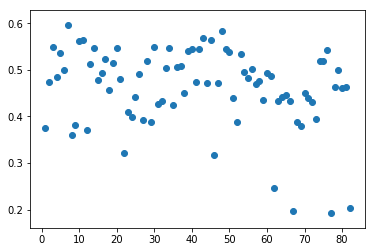

In [48]:
plt.scatter(gini_bos['g_num'], gini_bos['gini_9'])
plt.show()

In [49]:
np.mean(gini_bos['gini_9'])

0.46254855362369024

In [50]:
np.var(gini_bos['gini_9'])

0.00700347084034781

## Creating average Gini score per year

In [35]:
gini_avgs = pd.DataFrame()
for link in links:
    gini_log = pd.read_excel(link)
    yr = int(link[26:30])
    for team in np.unique(gini_log['team']):
        temp_df = gini_log[gini_log['team'] == team]
        #avg_gini_2 = np.mean(temp_df['gini_2'])
        #avg_gini_3 = np.mean(temp_df['gini_3'])
        #avg_gini_4 = np.mean(temp_df['gini_4'])
        avg_gini_5 = np.mean(temp_df['gini_5'])
        avg_gini_6 = np.mean(temp_df['gini_6'])
        avg_gini_7 = np.mean(temp_df['gini_7'])
        avg_gini_8 = np.mean(temp_df['gini_8'])
        avg_gini_9 = np.mean(temp_df['gini_9'])
        avg_gini_10 = np.mean(temp_df['gini_10'])
        #var_gini_2 = np.var(temp_df['gini_2'])
        #var_gini_3 = np.var(temp_df['gini_3'])
        #var_gini_4 = np.var(temp_df['gini_4'])
        var_gini_5 = np.var(temp_df['gini_5'])
        var_gini_6 = np.var(temp_df['gini_6'])
        var_gini_7 = np.var(temp_df['gini_7'])
        var_gini_8 = np.var(temp_df['gini_8'])
        var_gini_9 = np.var(temp_df['gini_9'])
        var_gini_10 = np.var(temp_df['gini_10'])
        #print team, avg_gini
        gini_avgs = gini_avgs.append({'team': team,
                                      'season': yr,
                                      #'avg_gini_2': avg_gini_2,
                                      #'avg_gini_3': avg_gini_3,
                                      #'avg_gini_4': avg_gini_4,
                                      'avg_gini_5': avg_gini_5,
                                      'avg_gini_6': avg_gini_6,
                                      'avg_gini_7': avg_gini_7,
                                      'avg_gini_8': avg_gini_8,
                                      'avg_gini_9': avg_gini_9,
                                      'avg_gini_10': avg_gini_10,
                                      #'var_gini_2': var_gini_2,
                                      #'var_gini_3': var_gini_3,
                                      #'var_gini_4': var_gini_4,
                                      'var_gini_5': var_gini_5,
                                      'var_gini_6': var_gini_6,
                                      'var_gini_7': var_gini_7,
                                      'var_gini_8': var_gini_8,
                                      'var_gini_9': var_gini_9,
                                      'var_gini_10': var_gini_10 
                                     }, 
                                      ignore_index=True)

In [36]:
gini_avgs

,avg_gini_10,avg_gini_5,avg_gini_6,avg_gini_7,avg_gini_8,avg_gini_9,season,team,var_gini_10,var_gini_5,var_gini_6,var_gini_7,var_gini_8,var_gini_9
0,0.547317,0.369684,0.401418,0.435794,0.470999,0.510773,1986.0,ATL,0.006380,0.007955,0.006622,0.006565,0.006824,0.006715
1,0.545335,0.275747,0.338501,0.397386,0.451679,0.503890,1986.0,BOS,0.005695,0.005794,0.005174,0.005050,0.005497,0.005643
2,0.470483,0.264703,0.299673,0.340958,0.387456,0.435019,1986.0,CHI,0.007700,0.007187,0.007074,0.007707,0.007764,0.007694
3,0.503409,0.278769,0.328455,0.375222,0.418784,0.463014,1986.0,CLE,0.005580,0.006000,0.005842,0.006017,0.006036,0.005895
4,0.480361,0.256544,0.296113,0.341626,0.392822,0.445365,1986.0,DAL,0.007283,0.005828,0.005479,0.005937,0.006660,0.007185
5,0.507518,0.306683,0.345096,0.385377,0.427058,0.472080,1986.0,DEN,0.006419,0.007478,0.007398,0.007083,0.007318,0.006922
6,0.473242,0.246021,0.291105,0.340109,0.387329,0.435913,1986.0,DET,0.008276,0.009619,0.010138,0.009117,0.009177,0.008845
7,0.537384,0.280416,0.337691,0.392440,0.447957,0.499576,1986.0,GSW,0.004262,0.006105,0.005256,0.005188,0.005147,0.004717
8,0.503356,0.264704,0.309776,0.363533,0.417899,0.469223,1986.0,HOU,0.005044,0.006070,0.005714,0.005526,0.005771,0.005642
9,0.483997,0.241829,0.283964,0.332621,0.386206,0.441142,1986.0,IND,0.005851,0.006274,0.006621,0.007101,0.006692,0.006301


In [37]:
gini_avgs.to_excel('data/gini_avgs_vars_mp2.xlsx')

## Graphs

In [68]:
s_res = pd.read_excel('data/nba_results.xlsx')
gini_avgs = pd.read_excel('data/gini_avgs_vars_mp2.xlsx')

In [69]:
s_res.head(n=20)

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1
5,Milwaukee Bucks,42,40,0.512,40,42,103.6,103.8,2017,MIL,1
6,Indiana Pacers,42,40,0.512,40,42,105.1,105.3,2017,IND,1
7,Chicago Bulls,41,41,0.500,42,40,102.9,102.4,2017,CHI,1
8,Miami Heat,41,41,0.500,44,38,103.2,102.1,2017,MIA,0
9,Detroit Pistons,37,45,0.451,38,44,101.3,102.5,2017,DET,0


In [70]:
print len(s_res)
len(s_res) == len(gini_avgs)

907


True

In [71]:
temp = gini_avgs[(gini_avgs['team'] == 'BOS') & (gini_avgs['season'] == 2017)]

In [72]:
temp['avg_gini_5'].values[0]

0.280660193263437

In [73]:
temp = gini_avgs[(gini_avgs['team'] == str(s_res.iloc[0].abbr)) & (gini_avgs['season'] == s_res.iloc[0].yr)]

In [74]:
temp

,avg_gini_10,avg_gini_5,avg_gini_6,avg_gini_7,avg_gini_8,avg_gini_9,season,team,var_gini_10,var_gini_5,var_gini_6,var_gini_7,var_gini_8,var_gini_9
878,0.504576,0.28066,0.327824,0.37354,0.418636,0.462549,2017,BOS,0.006128,0.007557,0.007103,0.007487,0.007412,0.007003


In [75]:
temp['avg_gini_5'].values[0]

0.280660193263437

In [76]:
gini_lst_5 = []
gini_lst_6 = []
gini_lst_7 = []
gini_lst_8 = []
gini_lst_9 = []
gini_lst_10 = []
var_lst_5 = []
var_lst_6 = []
var_lst_7 = []
var_lst_8 = []
var_lst_9 = []
var_lst_10 = []
for i in range(len(s_res)):
    print i
    temp = gini_avgs[(gini_avgs['team'] == str(s_res.iloc[i].abbr)) & (gini_avgs['season'] == s_res.iloc[i].yr)]
    gini_lst_5.append(temp['avg_gini_5'].values[0])
    gini_lst_6.append(temp['avg_gini_6'].values[0])
    gini_lst_7.append(temp['avg_gini_7'].values[0])
    gini_lst_8.append(temp['avg_gini_8'].values[0])
    gini_lst_9.append(temp['avg_gini_9'].values[0])
    gini_lst_10.append(temp['avg_gini_10'].values[0])
    var_lst_5.append(temp['var_gini_5'].values[0])
    var_lst_6.append(temp['var_gini_6'].values[0])
    var_lst_7.append(temp['var_gini_7'].values[0])
    var_lst_8.append(temp['var_gini_8'].values[0])
    var_lst_9.append(temp['var_gini_9'].values[0])
    var_lst_10.append(temp['var_gini_10'].values[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
gini_lst_5

[0.280660193263437,
 0.344794305348259,
 0.34380050164514803,
 0.28988181412103903,
 0.226092766182549,
 0.312391062789659,
 0.26976890412190802,
 0.28022357277757098,
 0.20237344972422699,
 0.17535872409734099,
 0.26430340691959098,
 0.285314642721264,
 0.190035144193095,
 0.18352846434657299,
 0.22950940378641499,
 0.32410961619183098,
 0.31359397984155701,
 0.31404834181622399,
 0.238882810757203,
 0.21940335182395601,
 0.40128033386998002,
 0.26009625591703001,
 0.30589406279725601,
 0.190129502882701,
 0.327389713040111,
 0.24107141715859901,
 0.289701912934481,
 0.30251498966171603,
 0.20825784788666299,
 0.30815553245258898,
 0.30403150224925701,
 0.32534617127941401,
 0.208165381205311,
 0.20381812150259301,
 0.272578546536068,
 0.22740396478482899,
 0.282215867525205,
 0.179625677368071,
 0.28221707065224599,
 0.27470685518646698,
 0.222355768192736,
 0.21439632353847299,
 0.29230863919350503,
 0.238051176407337,
 0.21468484825308501,
 0.338515229335004,
 0.25588568370391002,


In [96]:
#s_res['avg_gini_2'] = gini_lst_2
#s_res['avg_gini_3'] = gini_lst_3
#s_res['avg_gini_4'] = gini_lst_4
s_res['avg_gini_5'] = gini_lst_5
s_res['avg_gini_6'] = gini_lst_6
s_res['avg_gini_7'] = gini_lst_7
s_res['avg_gini_8'] = gini_lst_8
s_res['avg_gini_9'] = gini_lst_9
s_res['avg_gini_10'] = gini_lst_10
s_res['var_gini_5'] = var_lst_5
s_res['var_gini_6'] = var_lst_6
s_res['var_gini_7'] = var_lst_7
s_res['var_gini_8'] = var_lst_8
s_res['var_gini_9'] = var_lst_9
s_res['var_gini_10'] = var_lst_10

In [97]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,...,avg_var_7,avg_var_8,avg_var_9,avg_var_10,var_gini_5,var_gini_6,var_gini_7,var_gini_8,var_gini_9,var_gini_10
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,...,0.007487,0.007412,0.007003,0.006128,0.007557,0.007103,0.007487,0.007412,0.007003,0.006128
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,...,0.007764,0.008800,0.008667,0.007630,0.007208,0.007278,0.007764,0.008800,0.008667,0.007630
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,...,0.007557,0.007690,0.007440,0.006726,0.009006,0.007961,0.007557,0.007690,0.007440,0.006726
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,...,0.005754,0.005760,0.006035,0.005558,0.006841,0.006148,0.005754,0.005760,0.006035,0.005558
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,...,0.007000,0.008277,0.009470,0.009819,0.005589,0.006023,0.007000,0.008277,0.009470,0.009819


In [98]:
team = 'ATL'
yr = 1986
print gini_avgs[(gini_avgs['team'] == team) & (gini_avgs['season'] == yr)]
print s_res[(s_res['abbr'] == team) & (s_res['yr'] == yr)]

   avg_gini_10  avg_gini_5  avg_gini_6  avg_gini_7  avg_gini_8  avg_gini_9  \
0     0.547317    0.369684    0.401418    0.435794    0.470999    0.510773   

   season team  var_gini_10  var_gini_5  var_gini_6  var_gini_7  var_gini_8  \
0    1986  ATL      0.00638    0.007955    0.006622    0.006565    0.006824   

   var_gini_9  
0    0.006715  
              Team   W   L  WL_pct  PW  PL   PS/G   PA/G    yr abbr  \
890  Atlanta Hawks  50  32    0.61  47  35  108.6  106.2  1986  ATL   

        ...       avg_var_7  avg_var_8  avg_var_9  avg_var_10  var_gini_5  \
890     ...        0.006565   0.006824   0.006715     0.00638    0.007955   

     var_gini_6  var_gini_7  var_gini_8  var_gini_9  var_gini_10  
890    0.006622    0.006565    0.006824    0.006715      0.00638  

[1 rows x 29 columns]


In [99]:
s_res.to_excel('data/nba_results_with_ginis_vars.xlsx')

In [100]:
s_res = pd.read_excel('data/nba_results_with_ginis_vars.xlsx')

In [101]:
s_res_recent = s_res[s_res['yr'] >= 2003]
s_res_past = s_res[s_res['yr'] < 2003]

In [102]:
zip(s_res[s_res['playoffs'] == 5]['Team'], s_res[s_res['playoffs'] == 5]['avg_gini_5'])

[(u'Golden State Warriors', 0.324109616191831),
 (u'Cleveland Cavaliers', 0.304031502249257),
 (u'Golden State Warriors', 0.279424740346059),
 (u'San Antonio Spurs', 0.200880813458235),
 (u'Miami Heat', 0.342735295196352),
 (u'Miami Heat', 0.353417111169812),
 (u'Dallas Mavericks', 0.250671982895053),
 (u'Los Angeles Lakers', 0.326100592446235),
 (u'Los Angeles Lakers', 0.321282268694491),
 (u'Boston Celtics', 0.269445411987721),
 (u'San Antonio Spurs', 0.29442229673411),
 (u'Miami Heat', 0.330977782990938),
 (u'San Antonio Spurs', 0.296616418067378),
 (u'Detroit Pistons', 0.241359098387604),
 (u'San Antonio Spurs', 0.318769977580973),
 (u'Los Angeles Lakers', 0.401362209147734),
 (u'Los Angeles Lakers', 0.436631718809715),
 (u'Los Angeles Lakers', 0.411996851211959),
 (u'San Antonio Spurs', 0.292673642308226),
 (u'Chicago Bulls', 0.390028033205401),
 (u'Chicago Bulls', 0.398398912279589),
 (u'Chicago Bulls', 0.401326115125775),
 (u'Houston Rockets', 0.338670533923184),
 (u'Houston Roc

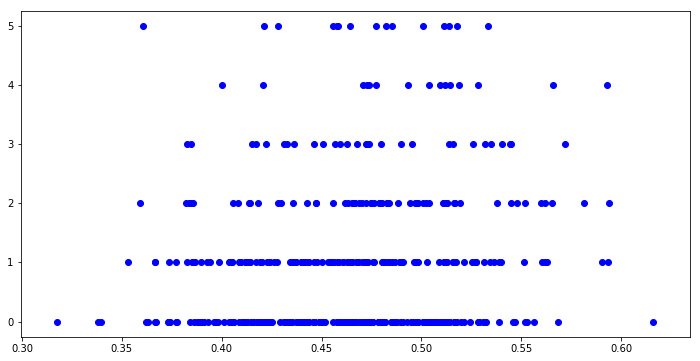

In [155]:
s_res = pd.read_excel('data/nba_results_with_ginis_vars.xlsx')
split = 2003
s_res_recent = s_res[s_res['yr'] >= split]
s_res_past = s_res[s_res['yr'] < split]
plt.figure(figsize=(12,6))
#plt.scatter(s_res_past['avg_gini_5'], s_res_past['playoffs'], c='r')
plt.scatter(s_res_recent['avg_gini_9'], s_res_recent['playoffs'], c='b')
plt.show()

In [156]:
def plot_gini_game_playoffs(k):
    s_res = pd.read_excel('data/nba_results_with_ginis_vars.xlsx')
    split = 2003
    var = 'avg_gini_' + str(k)
    s_res_recent = s_res[s_res['yr'] >= split]
    s_res_past = s_res[s_res['yr'] < split]
    plt.figure(figsize=(12,6))
    #plt.scatter(s_res_past['avg_gini_5'], s_res_past['playoffs'], c='r')
    plt.scatter(s_res_recent[var], s_res_recent['playoffs'], c='b')
    plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
    plt.xlabel('Avg. game Gini coefficient')
    plt.title('Avg. Gini vs. Playoff Success (k=' + str(k) + ', n=' + str(2) + ')')
    #plt.savefig('plots/testplot.png')
    plt.savefig('plots/gini_game_playoff_k' + str(k) + '_n' + str(2) +'.png', bbox_inches='tight')
    plt.show()

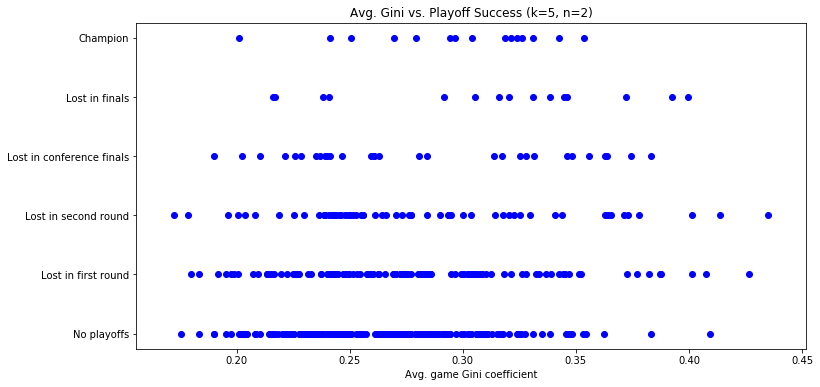

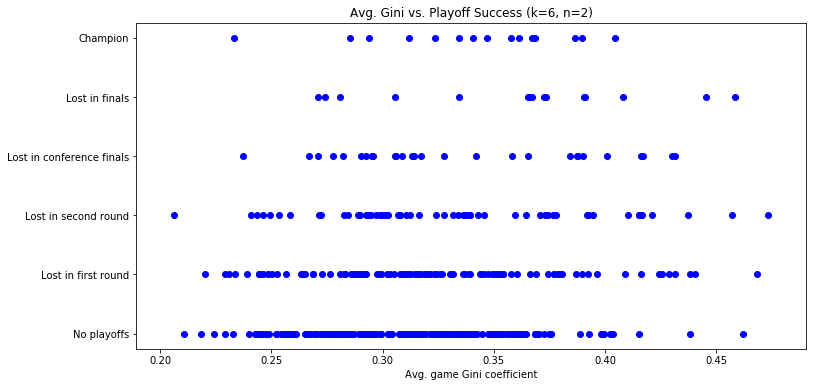

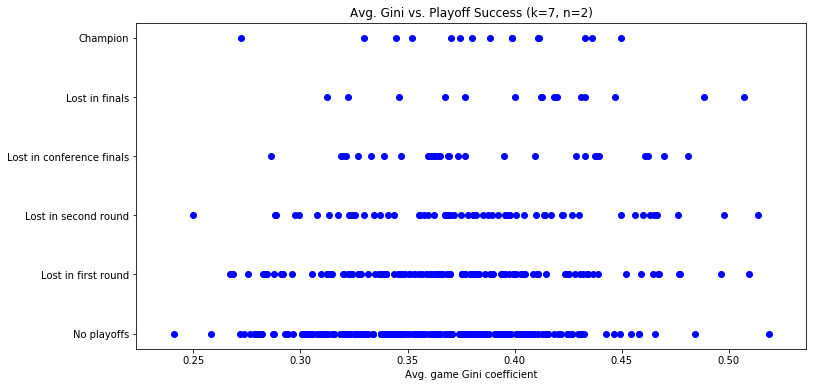

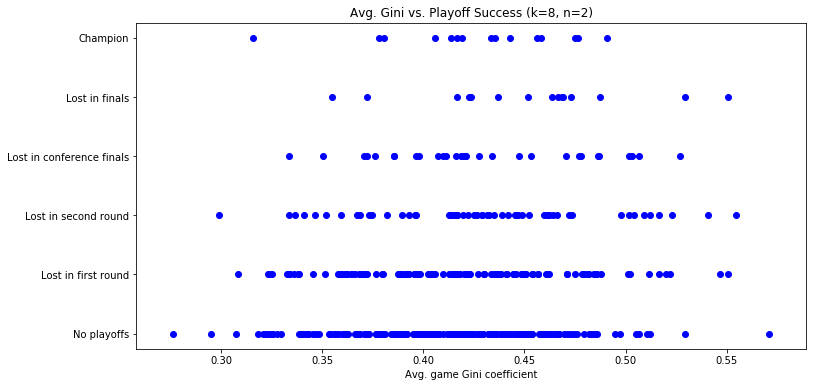

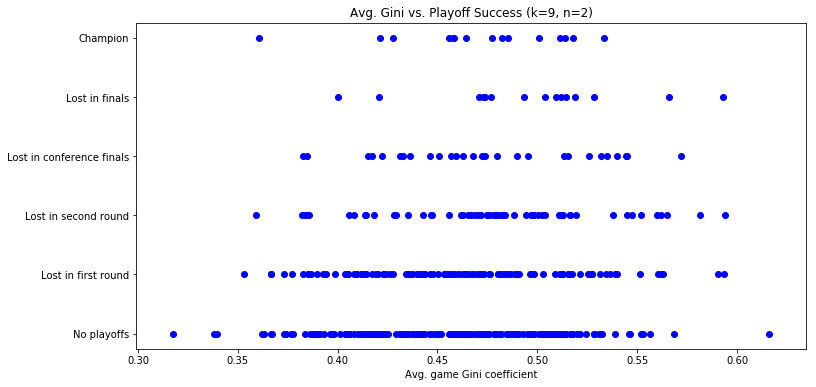

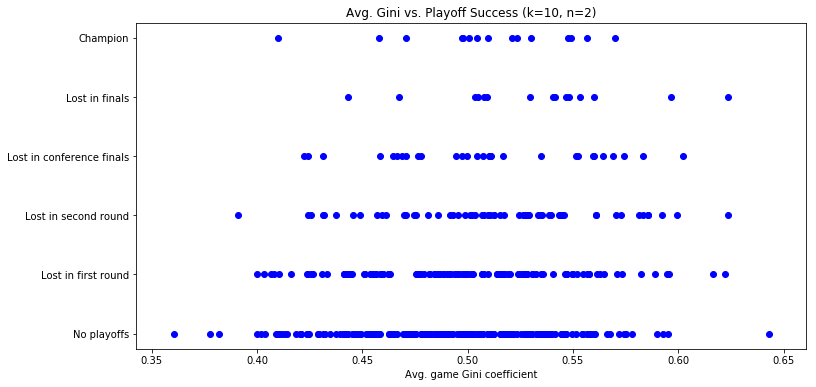

In [159]:
for i in range(5,11):
    plot_gini_game_playoffs(i)

In [104]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,...,avg_var_7,avg_var_8,avg_var_9,avg_var_10,var_gini_5,var_gini_6,var_gini_7,var_gini_8,var_gini_9,var_gini_10
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,...,0.007487,0.007412,0.007003,0.006128,0.007557,0.007103,0.007487,0.007412,0.007003,0.006128
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,...,0.007764,0.008800,0.008667,0.007630,0.007208,0.007278,0.007764,0.008800,0.008667,0.007630
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,...,0.007557,0.007690,0.007440,0.006726,0.009006,0.007961,0.007557,0.007690,0.007440,0.006726
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,...,0.005754,0.005760,0.006035,0.005558,0.006841,0.006148,0.005754,0.005760,0.006035,0.005558
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,...,0.007000,0.008277,0.009470,0.009819,0.005589,0.006023,0.007000,0.008277,0.009470,0.009819


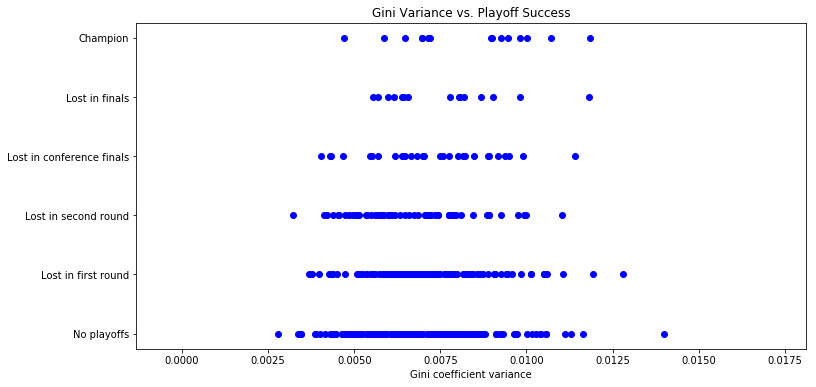

In [163]:
# Mean by variance
s_res = pd.read_excel('data/nba_results_with_ginis_vars.xlsx')
split = 2003
s_res_recent = s_res[s_res['yr'] >= split]
s_res_past = s_res[s_res['yr'] < split]
plt.figure(figsize=(12,6))
#plt.scatter(s_res_past['avg_gini_5'], s_res_past['playoffs'], c='r')
#plt.scatter(s_res_recent['avg_gini_9'], s_res_recent['var_gini_9'], c=s_res_recent['playoffs'])
plt.scatter(s_res_recent['var_gini_9'], s_res_recent['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
#plt.ylabel('')
plt.xlabel('Gini coefficient variance')
plt.title('Gini Variance vs. Playoff Success')
plt.savefig('plots/var_vs_playoff.png')
plt.show()

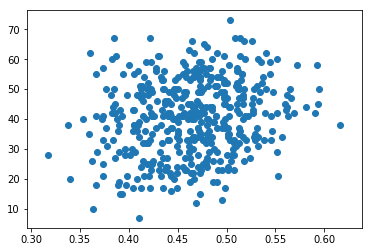

In [115]:
plt.scatter(s_res_recent['avg_gini_9'], s_res_recent['W'])
plt.show()

In [153]:
s2017 = s_res[s_res['yr'] == 2015]

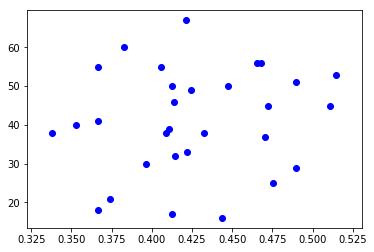

In [154]:
plt.scatter(s2017['avg_gini_9'], s2017['W'], c='b')
plt.show()